# Customer Segmentation using RFM Analysis

### Data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('ecommerce_data.csv',encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df['InvoiceNo'].nunique()

25900

In [8]:
print("Rows:",df.shape[0],"\nColumns:",df.shape[1])

Rows: 541909 
Columns: 8


In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
print(df["InvoiceDate"].max(),"\n",df["InvoiceDate"].min())

2011-12-09 12:50:00 
 2010-12-01 08:26:00


### Handling Missing Values

In [11]:
#Description: replacing the null values with a placeholder like "Not mentioned"
df['Description'].fillna('Not mentioned', inplace=True)

In [12]:
#CustomerID: dropping the missing value rows
df.dropna(subset=['CustomerID'], inplace=True)

In [13]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Data Overview Findings : 

##### What is the size of the dataset in terms of the number of rows and columns?
 Initially, there are 541909 rows and 8 columns
##### Can you provide a brief description of each column in the dataset? (change)
 InvoiceNo: Invoice number. A 6 digit number uniquely identifies each transaction.


StockCode: Product code. A  five digit number uniquely identifies each distinct product.


Description: Product name. 


Quantity: The quantities of each product per transaction.


InvoiceDate: The day and time when each transaction is generated.


UnitPrice: A numeric value that infers the product price per unit.


CustomerID: A five digit number uniquely identifies each customer.


Country: Name of the country where each customer resides.

##### What is the time period covered by this dataset?
The time period in the dataset is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00 

### Customer Analysis

In [14]:
# RFM Calculation

recency_df = df.groupby('CustomerID')['InvoiceDate'].max()
recency_df = (pd.to_datetime('today') - recency_df).dt.days

frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique()

monetary_df = df.groupby('CustomerID')['UnitPrice'].sum()

rfm_df = pd.DataFrame({
    'Recency': recency_df,
    'Frequency': frequency_df,
    'Monetary': monetary_df
})

rfm_df

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5149,2,2.08
12347.0,4826,7,481.21
12348.0,4899,4,178.71
12349.0,4842,1,605.10
12350.0,5134,1,65.30
...,...,...,...
18280.0,5101,1,47.65
18281.0,5004,1,39.36
18282.0,4831,3,62.68


In [15]:
# RFM Segmentation

quartiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([0, 0.25, 0.5, 0.75, 1]).to_dict()

def assign_score(value, metric):
    if value <= quartiles[metric][0.25]:
        return 4
    elif value <= quartiles[metric][0.5]:
        return 3
    elif value <= quartiles[metric][0.75]:
        return 2
    else:
        return 1

rfm_df['Recency_Score'] = rfm_df['Recency'].apply(lambda x: assign_score(x, 'Recency'))
rfm_df['Frequency_Score'] = rfm_df['Frequency'].apply(lambda x: assign_score(x, 'Frequency'))
rfm_df['Monetary_Score'] = rfm_df['Monetary'].apply(lambda x: assign_score(x, 'Monetary'))

#RFM score for each customer
rfm_df['RFM_Score'] = rfm_df['Recency_Score'].astype(str) + rfm_df['Frequency_Score'].astype(str) + rfm_df['Monetary_Score'].astype(str)


In [18]:
from sklearn.cluster import KMeans

# Define the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])


In [19]:
print(rfm_df.head())


            Recency  Frequency  Monetary  Recency_Score  Frequency_Score  \
CustomerID                                                                 
12346.0        5149          2      2.08              1                3   
12347.0        4826          7    481.21              4                1   
12348.0        4899          4    178.71              2                2   
12349.0        4842          1    605.10              3                4   
12350.0        5134          1     65.30              1                4   

            Monetary_Score RFM_Score  Cluster  
CustomerID                                     
12346.0                  4       134        0  
12347.0                  1       411        0  
12348.0                  2       222        0  
12349.0                  1       341        0  
12350.0                  3       143        0  


In [20]:
segment_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).reset_index()

print("Segment Profiles:")
print(segment_profiles)


Segment Profiles:
   Cluster      Recency  Frequency      Monetary
0        0  4919.257356   4.018331    194.429832
1        1  4886.333333  95.666667  37571.963333
2        2  4847.408257  21.830275   1793.917248
3        3  4843.400000  96.800000  19584.806000


Segment Profiles:
   Cluster      Recency  Frequency      Monetary
0        0  4919.257356   4.018331    194.429832
1        1  4886.333333  95.666667  37571.963333
2        2  4847.408257  21.830275   1793.917248
3        3  4843.400000  96.800000  19584.806000


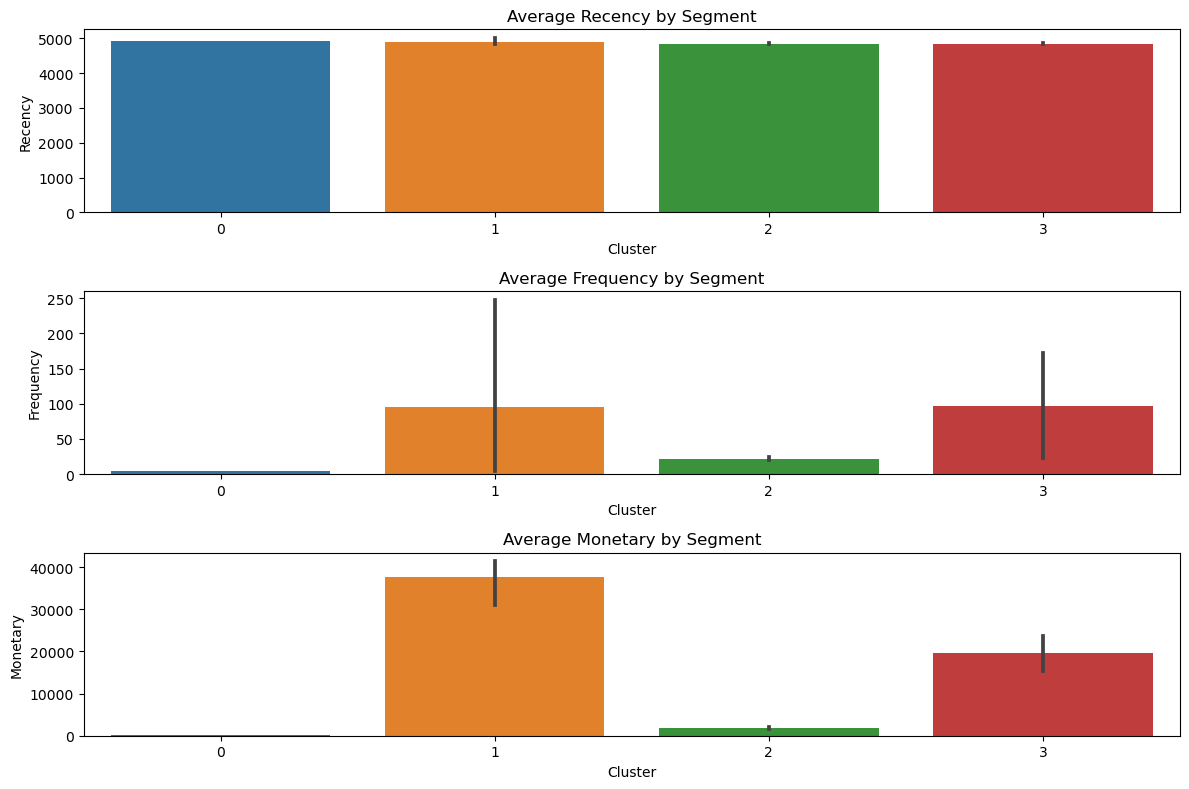

In [22]:
# Visualization of  RFM scores across segments

segment_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).reset_index()

print("Segment Profiles:")
print(segment_profiles)


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.barplot(x='Cluster', y='Recency', data=rfm_df, estimator='mean')
plt.title('Average Recency by Segment')

plt.subplot(3, 1, 2)
sns.barplot(x='Cluster', y='Frequency', data=rfm_df, estimator='mean')
plt.title('Average Frequency by Segment')

plt.subplot(3, 1, 3)
sns.barplot(x='Cluster', y='Monetary', data=rfm_df, estimator='mean')
plt.title('Average Monetary by Segment')

plt.tight_layout()
plt.show()


In [23]:
# Customer Analysis

unique_customers = rfm_df.index.nunique()
print("Number of Unique Customers:", unique_customers)

Number of Unique Customers: 4372


In [24]:
orders_per_customer= rfm_df['Frequency'].value_counts()
print("\nDistribution of Orders per Customer:\n", orders_per_customer)


Distribution of Orders per Customer:
 1     1313
2      817
3      490
4      377
5      288
      ... 
60       1
81       1
50       1
40       1
62       1
Name: Frequency, Length: 65, dtype: int64


In [25]:
top_5_customers = rfm_df.nlargest(5, 'Frequency')
print("\nTop 5 Customers by Order Count:\n", top_5_customers)


Top 5 Customers by Order Count:
             Recency  Frequency  Monetary  Recency_Score  Frequency_Score  \
CustomerID                                                                 
14911.0        4825        248  31060.66              4                1   
12748.0        4824        224  15115.60              4                1   
17841.0        4825        169  20333.18              4                1   
14606.0        4824        128   7839.02              4                1   
13089.0        4826        118   5166.45              4                1   

            Monetary_Score RFM_Score  Cluster  
CustomerID                                     
14911.0                  1       411        1  
12748.0                  1       411        3  
17841.0                  1       411        3  
14606.0                  1       411        2  
13089.0                  1       411        2  


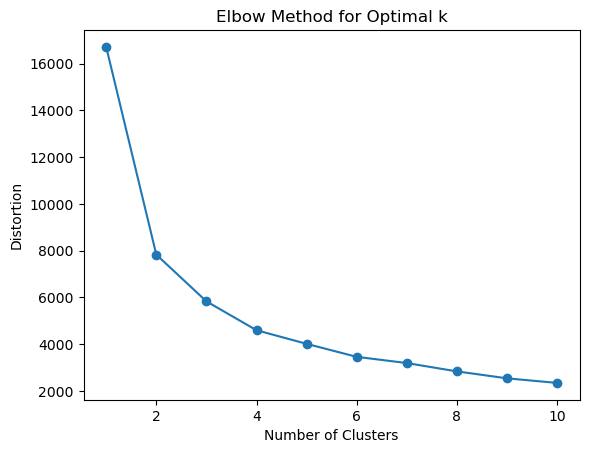

Number of clusters chosen: 3
Number of customers in each cluster:
2    1813
1    1620
0     939
Name: Cluster, dtype: int64


In [26]:
rfm_data = rfm_df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].astype(float)

def find_optimal_clusters(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()


find_optimal_clusters(rfm_data)
optimal_clusters = 3

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_data)

print("Number of clusters chosen:", optimal_clusters)
print("Number of customers in each cluster:")
print(rfm_df['Cluster'].value_counts())


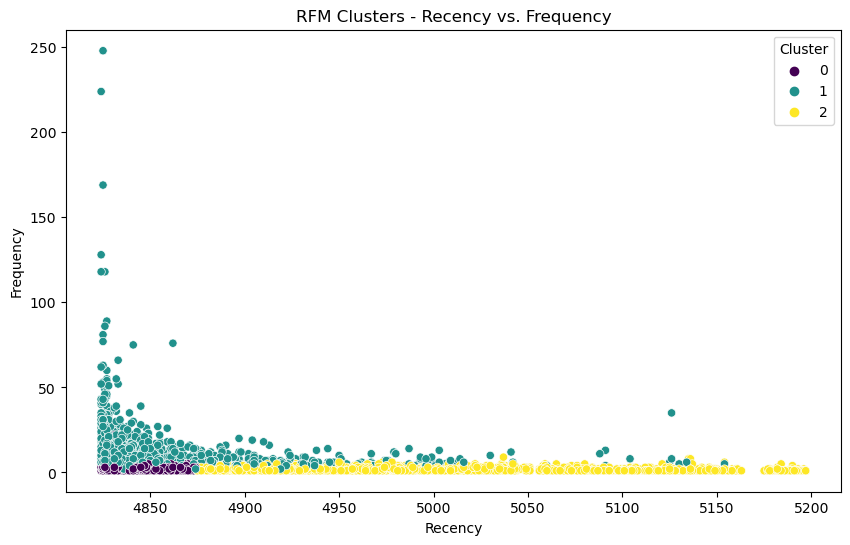

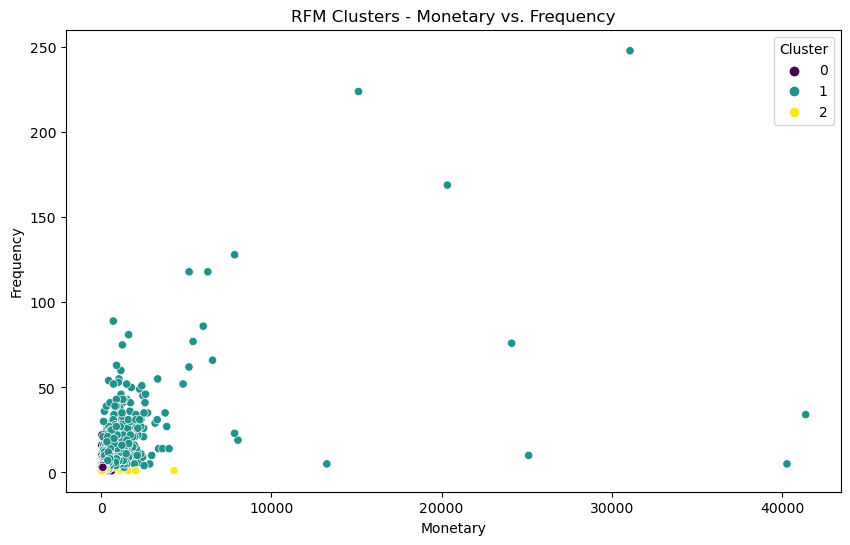

In [27]:
# RFM Distribution Visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('RFM Clusters - Recency vs. Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('RFM Clusters - Monetary vs. Frequency')
plt.show()

### Product Analysis

In [28]:
# Product Analysis 

df = pd.merge(df, rfm_df['RFM_Score'], left_on='CustomerID', right_index=True)

In [29]:
#Top 10 most frequently purchased products across all RFM segments
top_10_products_across_segments = df.groupby('Description')['Quantity'].sum().nlargest(10)
print("\nTop 10 Most Frequently Purchased Products Across All RFM Segments:\n", top_10_products_across_segments)


Top 10 Most Frequently Purchased Products Across All RFM Segments:
 Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53215
JUMBO BAG RED RETROSPOT               45066
ASSORTED COLOUR BIRD ORNAMENT         35314
WHITE HANGING HEART T-LIGHT HOLDER    34147
PACK OF 72 RETROSPOT CAKE CASES       33409
POPCORN HOLDER                        30504
RABBIT NIGHT LIGHT                    27094
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25321
PACK OF 60 PINK PAISLEY CAKE CASES    24163
Name: Quantity, dtype: int64


In [30]:
#Average price of products across all RFM segments
average_price_across_segments = df.groupby('RFM_Score')['UnitPrice'].mean()
print("\nAverage Price of Products Across All RFM Segments:\n", average_price_across_segments)


Average Price of Products Across All RFM Segments:
 RFM_Score
111     3.340803
112     3.580567
113     3.550909
114     3.271667
121    22.072588
         ...    
434     1.942540
441     3.693354
442     2.378326
443     2.352204
444     2.215358
Name: UnitPrice, Length: 64, dtype: float64


In [31]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = pd.merge(df, rfm_df['RFM_Score'], left_on='CustomerID', right_index=True)

#Product category generating the highest revenue across all RFM segments
highest_revenue_category = df.groupby('Description')['Revenue'].sum().idxmax()
print("\nProduct Category Generating the Highest Revenue Across All RFM Segments:\n",highest_revenue_category)


Product Category Generating the Highest Revenue Across All RFM Segments:
 REGENCY CAKESTAND 3 TIER


### Time Analysis

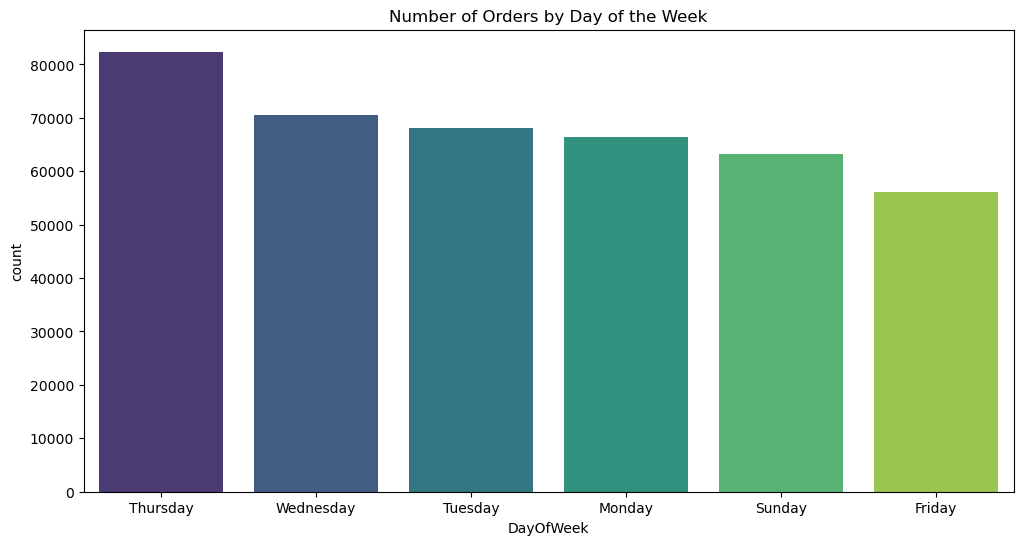

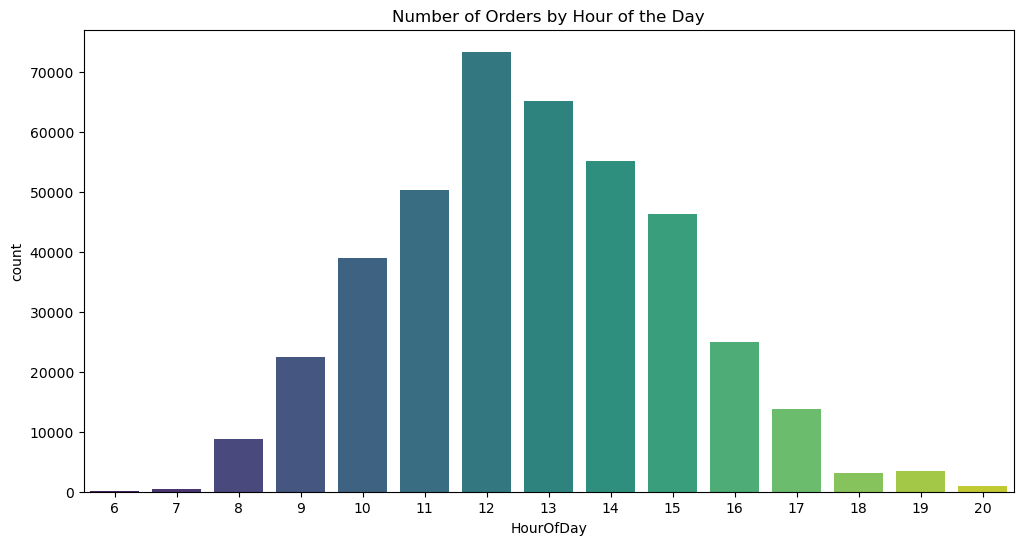

In [32]:
#To identify if there's a specific day of the week or time of day when most orders are placed

df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Visualizing the number of orders by day of the week
plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=df, order=df['DayOfWeek'].value_counts().index, palette='viridis')
plt.title('Number of Orders by Day of the Week')
plt.show()

# Visualizing the number of orders by hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='HourOfDay', data=df, palette='viridis')
plt.title('Number of Orders by Hour of the Day')
plt.show()


According to the above, highest orders are placed on Thursdays in a week and at around 12pm every day. 

In [33]:
rfm_df.to_csv('/Users/likhithaanuganti/Desktop/customer_segmentation_rfm.csv', index=True)


In [34]:
import os
print(os.getcwd())


/Users/likhithaanuganti
